In [152]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [153]:
 %matplotlib inline

## Generate Perlin Noise Map

In [154]:
#define noise map and final image

height = 255
width = 255
num_sites = 30
generated_image = np.ones((height, width))


#define to be noise values
noise_values = np.ones((height, width))


sites = np.random.rand(num_sites, 2)
sites[:, 0] = np.rint(sites[:, 0] * (height-1))
sites[:, 1] = np.rint(sites[:, 1] * (width-1))





In [155]:
import noise as noise
import random

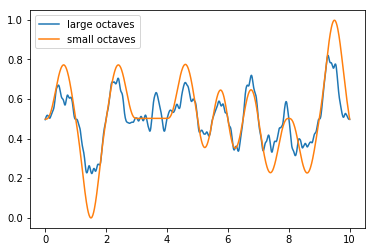

In [156]:
#for analyzing noise distributions

x_values = np.linspace(0, 10, num=800)
q = random.uniform(0.0, 10.0) #choose some random number between 0-10 to see how it'd vary on each axis
noise_func = lambda t, s: noise.pnoise2(t, q, octaves=s) + 0.5 #octaves is number of random pts sampled and interpolated per interval

noise_computer = np.vectorize(noise_func)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_values, noise_computer(x_values, 4), label="large octaves") 

ax.plot(x_values, noise_computer(x_values, 1), label="small octaves")
ax.legend()



In [157]:
#generate noise map

grid = np.indices((height, width))
np.moveaxis(grid, 0, -1)


noise_func = lambda t, s: noise.pnoise2((t[0]/height) * 10, (t[1]/width) * 10, octaves=s) + 0.5 #octaves is number of random pts sampled and interpolated per interval

noise_map = np.apply_along_axis(noise_func, 0, grid, 4)


print("min noise value: %f"% np.amin(noise_map))
print("max noise value: %f"% np.amax(noise_map))


min noise value: 0.028126
max noise value: 0.984622


## Generate Graph and Outline Image

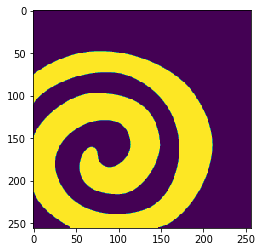

In [158]:
#Load content image
import cv2
image="side_fx_logo.png"
rgb_image = cv2.imread(image)

content = np.asarray(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY))
content = 255.0-content
content = content/255.0

plt.imshow(content)

In [205]:
import queue as q
import heapq
import functools
from lib.priority_dict import *
#define node class, 4 lattice graph of node objects

@functools.total_ordering

class Node(object): 
    def __init__(self, curr_site=(num_sites +1), priority=0.0, boundary=False, frontier=True, row=0, col=0):
        self.curr_site = curr_site
        self.boundary = boundary
        self.frontier = frontier
        self.priority = priority
        self.row = row
        self.col = col
    def __hash__(self):
        return int(str(self.row) + str(self.col))
    def __eq__(self, other):
        return self.row == other.row and self.col == other.col
    def __lt__(self, other):
        return self.priority < other.priority
    
#initialize start points for dijkstras
lattice = np.empty( (height,width), dtype=Node)

counter = 0
p_q = priority_dict()


#initialize sites
for site in sites:
    site = site.astype(int)
    temp_node = Node(counter, priority=0.0, row=site[0], col=site[1])
    
    lattice[site[0], site[1]] = temp_node
    p_q[temp_node] = 0.0
    counter= counter + 1
            
    

In [206]:
alpha = 6
beta =  1/6.0 * alpha
gamma = (alpha + beta) * 8


boundary_locations = set()

def calculate_cost(row, col, row_two, col_two):
    return beta + lattice[row, col].priority + (alpha * max(noise_map[row, col], noise_map[row_two, col_two])) + gamma * content[row + 1, col + 1]

def node_update(curr_node, row_two, col_two):
    sec_node = lattice[row_two, col_two]
    
    if curr_node.priority > 800:
        lattice[curr_node.row, curr_node.col].boundary = True
        boundary_locations.add(tuple((curr_node.row, curr_node.col)))
        
    if sec_node is None: #if not initialized yet
        cost = calculate_cost(curr_node.row, curr_node.col, row_two, col_two)
        lattice[row_two, col_two] = Node(curr_node.curr_site, priority = cost, row=row_two, col=col_two)  
        p_q[lattice[row_two, col_two]] = cost
        
    elif sec_node.frontier == True: #if frontier
        
        if sec_node.curr_site != curr_node.curr_site: #check if boundary node
            lattice[curr_node.row, curr_node.col].boundary = True
            boundary_locations.add(tuple((curr_node.row, curr_node.col)))
            
        cost = calculate_cost(curr_node.row, curr_node.col, sec_node.row, sec_node.col) #attempt cost update
        if cost < sec_node.priority: 
            p_q[lattice[sec_node.row, sec_node.col]] = cost
            lattice[sec_node.row, sec_node.col].priority = cost
                
            
                
                
while p_q:
    
    curr_node = p_q.pop_smallest()
    lattice[curr_node.row, curr_node.col].frontier = False
    
    
    if curr_node.row - 1 >= 0:
        node_update(curr_node, curr_node.row - 1, curr_node.col)
    if curr_node.row + 1 < height:
        node_update(curr_node, curr_node.row + 1, curr_node.col)
    if curr_node.col - 1 >= 0:
        node_update(curr_node,  curr_node.row, curr_node.col -1)
    if curr_node.col + 1 < width:
        node_update(curr_node, curr_node.row, curr_node.col + 1)

    
    

In [207]:
color_list = [[1.0, 0.0, 0.0], [0.2, 0.3, 0.4], [0.8, 0.5, 0.8], [0.1, 0.4, 0.2], [0.4, 0.1, 0.5], [0.2, 0.9, 0.1], [0.3, 0.6, 0.1], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [1.0, 1.0, 0], [1.0, 0.0, 1.0], [0.0, 1.0, 1.0]]
boundary_color = [0.0, 0.0, 0.0]

In [208]:
img_for_interm_analysis = np.ones((height, width, 3));
for r in range(0, height): 
    for c in range(0, width):
        #img_for_interm_analysis[r, c] = np.asarray(color_list[lattice[r,c].curr_site%12])
        img_for_interm_analysis[r, c] = np.asarray([1.0, 1.0, 1.0])
        if lattice[r, c].boundary == True:
            img_for_interm_analysis[r, c] = np.asarray(boundary_color)

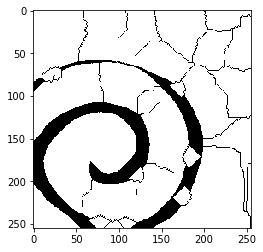

In [209]:
plt.imshow(img_for_interm_analysis)

## Crack Width Tapering

In [210]:
def bresenham(x1, y1, x2, y2, x_start, flipped):
    y = y1 
    twice_dx = 2 * (x2 - x1)
    twice_dy = 2 * (y2 - y1);
    twice_dy_minus_twice_dx = twice_dy - twice_dx;
    d = twice_dx // 2 - twice_dy;
    if x_start > x2:
        x_start = x_start + x2
        x2 = x_start - x2
        x_start = x_start - x2
    
    for x in range(x_start, x2):
        if flipped == True:
            if(x<0 or x>=height):
                continue;
            lattice[x, y].boundary = True
        else: 
            if(y<0 or y>=height):
                continue;
            lattice[y, x].boundary = True 
        if d > 0: 
            d -= twice_dy
        else:
            y= (y + 1); 
            d -= twice_dy_minus_twice_dx 


def flood_fill_depth(depth, r, c): 
    q_f = q.Queue()
    iteration = 0
    q_f.put(lattice[r, c])
    while iteration < depth and not q_f.empty():
        curr_node = q_f.get()
        r = curr_node.row
        c = curr_node.col
        
        if c+1 < width:
            if lattice[r, c+1].curr_site == curr_node.curr_site:
                q_f.put(lattice[r, c+1])
                lattice[r, c+1].boundary = True
        if c-1 >= 0:
            if lattice[r, c-1].curr_site == curr_node.curr_site:
                q_f.put(lattice[r, c-1])
                lattice[r, c-1].boundary = True
        if r+1 < height:
            if lattice[r+1, c].curr_site == curr_node.curr_site:
                q_f.put(lattice[r+1, c])
                lattice[r+1, c].boundary = True
        if r-1 >= 0:
            if lattice[r-1, c].curr_site == curr_node.curr_site:
                q_f.put(lattice[r-1, c])
                lattice[r-1, c].boundary = True
        iteration = iteration + 1

for loc in boundary_locations:
    vornoi_site = lattice[loc[0], loc[1]].curr_site
    vornoi_site_data = sites[vornoi_site].astype(int)
    manhattan = vornoi_site_data - np.asarray([loc[0],loc[1]], dtype=np.int32)
    delta_y = manhattan[0]
    delta_x = manhattan[1]
    
    
    #attempt with basic flood fill
    euclidean_distance = (delta_y**2 + delta_x**2)**(1/2)
    depth = int(0.02 * euclidean_distance)
    flood_fill_depth(depth, loc[0], loc[1])
    
    #attempt with bresenham by extending line along euclidean displacement vector -- currently doesn't work
    
    #if abs(delta_y) > abs(delta_x):
        #slope is greater than 1
        #bresenham(vornoi_site_data[0],vornoi_site_data[1], loc[0], loc[1], loc[0] + int(0.1 * delta_x)//delta_y, True)
    #else: 
        #print("loc 1: %d vornoi site: %d start %d"%(loc[1], vornoi_site_data[1], (loc[1] + delta_x//10)))
        #bresenham(vornoi_site_data[1], vornoi_site_data[0], loc[1], loc[0], (loc[1] + int(0.1 * delta_y)//delta_x), False)

    
    
    

## Display Outline Image

In [211]:
color_list = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [1.0, 1.0, 0], [1.0, 0.0, 1.0], [0.0, 1.0, 1.0]]
boundary_color = [0.0, 0.0, 0.0]

In [212]:
img_for_interm_analysis = np.ones((height, width, 3));
for r in range(0, height): 
    for c in range(0, width):
        img_for_interm_analysis[r, c] = np.asarray([1.0, 1.0, 1.0])
        if lattice[r, c].boundary == True:
            img_for_interm_analysis[r, c] = np.asarray(boundary_color)

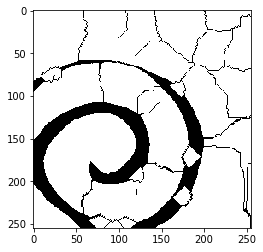

In [213]:
plt.imshow(img_for_interm_analysis)

## Transfer Outline onto Texture

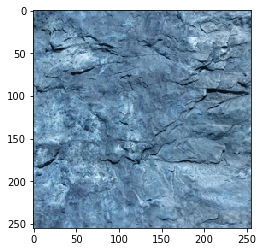

In [214]:
from PIL import Image, ImageFile
cv2.imwrite('outline_image.jpg', img_for_interm_analysis * 255)

styler = np.asarray(cv2.imread('texture.png'))
plt.imshow(styler)

In [175]:
from PIL import Image, ImageFile

epsilon = -1.0

result = np.multiply(styler/255.0, (1 - np.exp(epsilon * img_for_interm_analysis)))
print(result.shape)



cv2.imwrite('result.jpg', result * 255)
cv2.imshow("image", result)

(255, 255, 3)


### Style Transfer Attempt, Image Analogies were also attempted using a 3rd Party Image Analogy Python Utility 

In [215]:
#below is an attempt using style transfer
# most of the code for style transfer comes from here, with only minor modifications, and should thus not be mistaken for 
# being original: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/15_Style_Transfer.ipynb
import tensorflow as tf
tf.__version__
from lib.tfmodels import vgg16

vgg16.maybe_download()

Data has apparently already been downloaded and unpacked.


In [ ]:
import PIL.Image
def plot_image_big(image):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)
    print(image)

    # Convert pixels to bytes.
    image = image.astype(np.uint8)

    # Convert to a PIL-image and display it.
    display(PIL.Image.fromarray(image))

In [ ]:
def plot_images(content_image, style_image, mixed_image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'sinc'
    else:
        interpolation = 'nearest'

    # Plot the content-image.
    # Note that the pixel-values are normalized to
    # the [0.0, 1.0] range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Content")

    # Plot the mixed-image.
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Mixed")

    # Plot the style-image
    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Style")

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [ ]:
def mean_squared_error(a, b):
    return tf.reduce_mean(tf.square(a - b))

In [ ]:
def create_content_loss(session, model, content_image, layer_ids):
    """
    Create the loss-function for the content-image.
    
    Parameters:
    session: An open TensorFlow session for running the model's graph.
    model: The model, e.g. an instance of the VGG16-class.
    content_image: Numpy float array with the content-image.
    layer_ids: List of integer id's for the layers to use in the model.
    """
    
    # Create a feed-dict with the content-image.
    feed_dict = model.create_feed_dict(image=content_image)

    # Get references to the tensors for the given layers.
    layers = model.get_layer_tensors(layer_ids)

    # Calculate the output values of those layers when
    # feeding the content-image to the model.
    values = session.run(layers, feed_dict=feed_dict)

    # Set the model's graph as the default so we can add
    # computational nodes to it. It is not always clear
    # when this is necessary in TensorFlow, but if you
    # want to re-use this code then it may be necessary.
    with model.graph.as_default():
        # Initialize an empty list of loss-functions.
        layer_losses = []
    
        # For each layer and its corresponding values
        # for the content-image.
        for value, layer in zip(values, layers):
            # These are the values that are calculated
            # for this layer in the model when inputting
            # the content-image. Wrap it to ensure it
            # is a const - although this may be done
            # automatically by TensorFlow.
            value_const = tf.constant(value)

            # The loss-function for this layer is the
            # Mean Squared Error between the layer-values
            # when inputting the content- and mixed-images.
            # Note that the mixed-image is not calculated
            # yet, we are merely creating the operations
            # for calculating the MSE between those two.
            loss = mean_squared_error(layer, value_const)

            # Add the loss-function for this layer to the
            # list of loss-functions.
            layer_losses.append(loss)
            
        # The combined loss for all layers is just the average.
        # The loss-functions could be weighted differently for
        # each layer. You can try it and see what happens.
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

In [ ]:
def gram_matrix(tensor):
    shape = tensor.get_shape()
    
    # Get the number of feature channels for the input tensor,
    # which is assumed to be from a convolutional layer with 4-dim.
    num_channels = int(shape[3])

    # Reshape the tensor so it is a 2-dim matrix. This essentially
    # flattens the contents of each feature-channel.
    matrix = tf.reshape(tensor, shape=[-1, num_channels])
    
    # Calculate the Gram-matrix as the matrix-product of
    # the 2-dim matrix with itself. This calculates the
    # dot-products of all combinations of the feature-channels.
    gram = tf.matmul(tf.transpose(matrix), matrix)

    return gram

In [ ]:
def create_style_loss(session, model, style_image, layer_ids):
    """
    Create the loss-function for the style-image.
    
    Parameters:
    session: An open TensorFlow session for running the model's graph.
    model: The model, e.g. an instance of the VGG16-class.
    style_image: Numpy float array with the style-image.
    layer_ids: List of integer id's for the layers to use in the model.
    """

    # Create a feed-dict with the style-image.
    feed_dict = model.create_feed_dict(image=style_image)

    # Get references to the tensors for the given layers.
    layers = model.get_layer_tensors(layer_ids)

    # Set the model's graph as the default so we can add
    # computational nodes to it. It is not always clear
    # when this is necessary in TensorFlow, but if you
    # want to re-use this code then it may be necessary.
    with model.graph.as_default():
        # Construct the TensorFlow-operations for calculating
        # the Gram-matrices for each of the layers.
        gram_layers = [gram_matrix(layer) for layer in layers]

        # Calculate the values of those Gram-matrices when
        # feeding the style-image to the model.
        values = session.run(gram_layers, feed_dict=feed_dict)

        # Initialize an empty list of loss-functions.
        layer_losses = []
        
        # For each Gram-matrix layer and its corresponding values.
        for value, gram_layer in zip(values, gram_layers):
            # These are the Gram-matrix values that are calculated
            # for this layer in the model when inputting the
            # style-image. Wrap it to ensure it is a const,
            # although this may be done automatically by TensorFlow.
            value_const = tf.constant(value)

            # The loss-function for this layer is the
            # Mean Squared Error between the Gram-matrix values
            # for the content- and mixed-images.
            # Note that the mixed-image is not calculated
            # yet, we are merely creating the operations
            # for calculating the MSE between those two.
            loss = mean_squared_error(gram_layer, value_const)

            # Add the loss-function for this layer to the
            # list of loss-functions.
            layer_losses.append(loss)

        # The combined loss for all layers is just the average.
        # The loss-functions could be weighted differently for
        # each layer. You can try it and see what happens.
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

In [ ]:
def create_denoise_loss(model):
    loss = tf.reduce_sum(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + \
           tf.reduce_sum(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:]))

    return loss

In [ ]:
def style_transfer(content_image, style_image,
                   content_layer_ids, style_layer_ids,
                   weight_content=1.5, weight_style=10.0,
                   weight_denoise=0.3,
                   num_iterations=120, step_size=10.0):
    """
    Use gradient descent to find an image that minimizes the
    loss-functions of the content-layers and style-layers. This
    should result in a mixed-image that resembles the contours
    of the content-image, and resembles the colours and textures
    of the style-image.
    
    Parameters:
    content_image: Numpy 3-dim float-array with the content-image.
    style_image: Numpy 3-dim float-array with the style-image.
    content_layer_ids: List of integers identifying the content-layers.
    style_layer_ids: List of integers identifying the style-layers.
    weight_content: Weight for the content-loss-function.
    weight_style: Weight for the style-loss-function.
    weight_denoise: Weight for the denoising-loss-function.
    num_iterations: Number of optimization iterations to perform.
    step_size: Step-size for the gradient in each iteration.
    """

    # Create an instance of the VGG16-model. This is done
    # in each call of this function, because we will add
    # operations to the graph so it can grow very large
    # and run out of RAM if we keep using the same instance.
    model = vgg16.VGG16()

    # Create a TensorFlow-session.
    session = tf.InteractiveSession(graph=model.graph)

    # Print the names of the content-layers.
    print("Content layers:")
    print(model.get_layer_names(content_layer_ids))
    print()

    # Print the names of the style-layers.
    print("Style layers:")
    print(model.get_layer_names(style_layer_ids))
    print()

    # Create the loss-function for the content-layers and -image.
    loss_content = create_content_loss(session=session,
                                       model=model,
                                       content_image=content_image,
                                       layer_ids=content_layer_ids)

    # Create the loss-function for the style-layers and -image.
    loss_style = create_style_loss(session=session,
                                   model=model,
                                   style_image=style_image,
                                   layer_ids=style_layer_ids)    

    # Create the loss-function for the denoising of the mixed-image.
    loss_denoise = create_denoise_loss(model)
    
    # Create TensorFlow variables for adjusting the values of
    # the loss-functions. This is explained below.
    adj_content = tf.Variable(1e-10, name='adj_content')
    adj_style = tf.Variable(1e-10, name='adj_style')
    adj_denoise = tf.Variable(1e-10, name='adj_denoise')

    # Initialize the adjustment values for the loss-functions.
    session.run([adj_content.initializer,
                 adj_style.initializer,
                 adj_denoise.initializer])

    # Create TensorFlow operations for updating the adjustment values.
    # These are basically just the reciprocal values of the
    # loss-functions, with a small value 1e-10 added to avoid the
    # possibility of division by zero.
    update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
    update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
    update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))

    # This is the weighted loss-function that we will minimize
    # below in order to generate the mixed-image.
    # Because we multiply the loss-values with their reciprocal
    # adjustment values, we can use relative weights for the
    # loss-functions that are easier to select, as they are
    # independent of the exact choice of style- and content-layers.
    loss_combined = weight_content * adj_content * loss_content + \
                    weight_style * adj_style * loss_style + \
                    weight_denoise * adj_denoise * loss_denoise

    # Use TensorFlow to get the mathematical function for the
    # gradient of the combined loss-function with regard to
    # the input image.
    gradient = tf.gradients(loss_combined, model.input)
    
    # List of tensors that we will run in each optimization iteration.
    run_list = [gradient, update_adj_content, update_adj_style, \
                update_adj_denoise]

    # The mixed-image is initialized with random noise.
    # It is the same size as the content-image.
    mixed_image = np.random.rand(*content_image.shape) + 128
    
    for i in range(num_iterations):
        # Create a feed-dict with the mixed-image.
        feed_dict = model.create_feed_dict(image=mixed_image)

        # Use TensorFlow to calculate the value of the
        # gradient, as well as updating the adjustment values.
        grad, adj_content_val, adj_style_val, adj_denoise_val \
        = session.run(run_list, feed_dict=feed_dict)

        # Reduce the dimensionality of the gradient.
        grad = np.squeeze(grad)

        # Scale the step-size according to the gradient-values.
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Update the image by following the gradient.
        mixed_image -= grad * step_size_scaled

        # Ensure the image has valid pixel-values between 0 and 255.
        mixed_image = np.clip(mixed_image, 0.0, 255.0)

        # Print a little progress-indicator.
        print(". ", end="")

        # Display status once every 10 iterations, and the last.
        if (i % 10 == 0) or (i == num_iterations - 1):
            print()
            print("Iteration:", i)

            # Print adjustment weights for loss-functions.
            msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))

            # Plot the content-, style- and mixed-images.
            plot_images(content_image=content_image,
                        style_image=style_image,
                        mixed_image=mixed_image)
            

    print("Final image:")
    plot_image_big(mixed_image)

    # Close the TensorFlow session to release its resources.
    session.close()
    
    # Return the mixed-image.
    return mixed_image

In [ ]:
content_image = img_for_interm_analysis
style_image = styler/255.0
content_layer_ids = [4]
# The VGG16-model has 13 convolutional layers.
# This selects all those layers as the style-layers.
# This is somewhat slow to optimize.
style_layer_ids = [0, 2, 4, 7, 10]

# You can also select a sub-set of the layers, e.g. like this:
# style_layer_ids = [1, 2, 3, 4]

In [ ]:
%%time
img = style_transfer(content_image=content_image * 255.0,
                     style_image=style_image * 255.0,
                     content_layer_ids=content_layer_ids,
                     style_layer_ids=style_layer_ids,
                     weight_content=8.0,
                     weight_style=10.0,
                     weight_denoise=0.3,
                     num_iterations=100,
                     step_size=10.0)